# **Import Libraries**

In [1]:
!pip install pytorch-fid

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import random
import pytorch_fid
from torch.utils.data import DataLoader
from torch.autograd import Variable
from math import exp
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading Dataset**

In [4]:
file_name = "./drive/MyDrive/NN-HW6/sh3_sc6_y32_x32_imgs.npz"
imgs = np.load(file_name, allow_pickle=True, encoding='latin1')
imgs = imgs['imgs']

In [5]:
imgs = imgs.reshape(imgs.shape[0], 1, imgs.shape[1], imgs.shape[2])

In [6]:
print_imgs = random.choices(imgs, k=50)
test_imgs = random.choices(imgs, k=5000)

# **VAE Model**

In [7]:
# Define the VAE architecture in PyTorch
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(64, 256, kernel_size=4, stride=1)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 20)
        self.latent_dim = latent_dim

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = x.view(-1, 256)
        x = self.fc1(x)
        x = self.fc2(x)
        mean = x[:, :self.latent_dim]
        log_var = x[:, self.latent_dim:]
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.deconv1 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=1)
        self.deconv2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = x.view(-1, 256, 1, 1)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.relu(self.deconv3(x))
        x = torch.relu(self.deconv4(x))
        x = self.deconv5(x)
        return x

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        recon_x = self.decoder(z)
        return recon_x, mean, log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(mean)
        return mean + std * eps

In [8]:
class VAE_Loss(nn.Module):
    def __init__(self):
        super(VAE_Loss, self).__init__()

    def forward(self, recon_x, x, mean, log_var):
        # Reconstruction loss (Bernoulli likelihood)
        recon_loss = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum').div(x.size(0))

        # KL Divergence loss
        kl_loss = -0.5 * (1 + log_var - mean.pow(2) - log_var.exp())
        kl_loss_total = kl_loss.sum(1).mean(0)

        return recon_loss, kl_loss_total


In [9]:
# Define the training function
def train_vae(vae, train_loader, optimizer, criterion, epochs, device):
    vae.train()

    recon_loss_list = []
    kl_loss_list = []
    sum_loss_list = []

    for epoch in range(epochs):
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data.float().to(device)
            optimizer.zero_grad()
            recon_batch, mean, log_var = vae(data)
            recon_loss, kl_loss = criterion(recon_batch, data, mean, log_var)
            loss = (recon_loss) + kl_loss
            loss.backward()
            optimizer.step()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            total_loss += loss.item()

        recon_loss_list.append(total_recon_loss/len(train_loader.dataset))
        kl_loss_list.append(total_kl_loss/len(train_loader.dataset))
        sum_loss_list.append(total_loss/len(train_loader.dataset))

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader.dataset):.4f}')

    return recon_loss_list, kl_loss_list, sum_loss_list

In [10]:
if (torch.cuda.is_available()):
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

In [11]:
epochs = 200

latent_dim = 10
encoder = Encoder(latent_dim).to(DEVICE)
decoder = Decoder(latent_dim).to(DEVICE)
vae = VAE(encoder, decoder).to(DEVICE)

# Define the optimizer and loss function
optimizer = optim.Adam(vae.parameters(), lr=0.0001)
criterion = VAE_Loss()

train_loader = DataLoader(imgs, batch_size=32, shuffle=True)

# Train the VAE
recon_loss, kl_loss, total_loss = train_vae(vae, train_loader, optimizer, criterion, epochs, DEVICE)

Epoch 1/200, Loss: 26.4593
Epoch 2/200, Loss: 6.4730
Epoch 3/200, Loss: 3.7834
Epoch 4/200, Loss: 3.5562
Epoch 5/200, Loss: 3.4381
Epoch 6/200, Loss: 3.3342
Epoch 7/200, Loss: 3.1987
Epoch 8/200, Loss: 2.9570
Epoch 9/200, Loss: 2.6695
Epoch 10/200, Loss: 2.4795
Epoch 11/200, Loss: 2.3547
Epoch 12/200, Loss: 2.2643
Epoch 13/200, Loss: 2.1998
Epoch 14/200, Loss: 2.1390
Epoch 15/200, Loss: 2.0857
Epoch 16/200, Loss: 2.0282
Epoch 17/200, Loss: 1.9775
Epoch 18/200, Loss: 1.9385
Epoch 19/200, Loss: 1.8817
Epoch 20/200, Loss: 1.8352
Epoch 21/200, Loss: 1.7975
Epoch 22/200, Loss: 1.7547
Epoch 23/200, Loss: 1.7204
Epoch 24/200, Loss: 1.6792
Epoch 25/200, Loss: 1.6495
Epoch 26/200, Loss: 1.6153
Epoch 27/200, Loss: 1.5929
Epoch 28/200, Loss: 1.5669
Epoch 29/200, Loss: 1.5443
Epoch 30/200, Loss: 1.5200
Epoch 31/200, Loss: 1.4961
Epoch 32/200, Loss: 1.4742
Epoch 33/200, Loss: 1.4598
Epoch 34/200, Loss: 1.4378
Epoch 35/200, Loss: 1.4159
Epoch 36/200, Loss: 1.4052
Epoch 37/200, Loss: 1.3823
Epoch 38/

Text(0.5, 1.0, 'total loss')

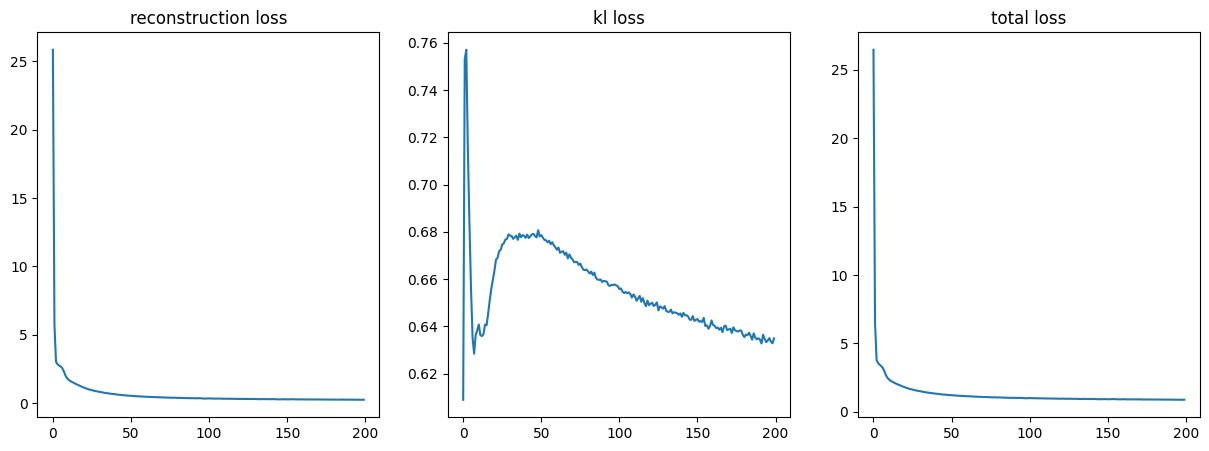

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(recon_loss)
plt.title('reconstruction loss')
plt.subplot(1, 3, 2)
plt.plot(kl_loss)
plt.title('kl loss')
plt.subplot(1, 3, 3)
plt.plot(total_loss)
plt.title('total loss')

In [13]:
print_imgs = DataLoader(print_imgs, batch_size=50, shuffle=False)
for img in print_imgs:
    print_imgs = img
imgs_recon = vae(print_imgs.to(DEVICE).float())[0]
imgs_recon = nn.Sigmoid()(imgs_recon).cpu().detach().numpy()

Text(0.5, 1.0, 'reconstructed images')

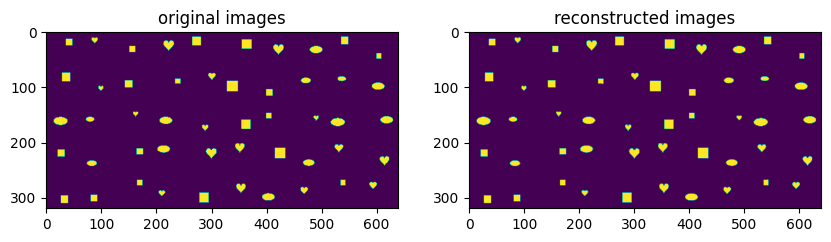

In [14]:
def image_grid(array, ncols=10):
    index, channels, height, width = array.shape
    nrows = index//ncols

    img_grid = (array.reshape(nrows, ncols, height, width, channels)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))

    return img_grid

org = image_grid(np.array(print_imgs))
rec = image_grid(np.array(imgs_recon))
fig = plt.figure(figsize=(10., 10.))
plt.subplot(1, 2, 1)
plt.imshow(org)
plt.title('original images')
plt.subplot(1, 2, 2)
plt.imshow(rec)
plt.title('reconstructed images')

In [15]:
!rm -rf aa
!rm -rf bb
!mkdir aa
!mkdir bb

In [16]:
test_imgs = DataLoader(test_imgs, batch_size=50, shuffle=False)
for img in test_imgs:
    test_imgs = img
imgs_recon = vae(print_imgs.to(DEVICE).float())[0]
imgs_recon = nn.Sigmoid()(imgs_recon).cpu().detach().numpy()

In [17]:
cnt = 0
for i in imgs_recon:
  cnt += 1
  result = Image.fromarray((i[0] * 255).astype(np.uint8))
  result.save('./aa/'+str(cnt)+'.bmp')
cnt = 0
for i in test_imgs:
  cnt += 1
  result = Image.fromarray((np.array(i[0]) * 255).astype(np.uint8))
  result.save('./bb/'+str(cnt)+'.bmp')

In [18]:
!python -m pytorch_fid './aa' './bb' --dims 64 --device cuda:0

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 317MB/s]
100% 1/1 [00:00<00:00,  2.78it/s]
100% 1/1 [00:00<00:00,  7.85it/s]
FID:  0.002265493924755224


# **ControlVAE Model - sp=8**

In [19]:
class PIDControl():
    def __init__(self):
        self.I_k_1 = 0.0
        self.W_k_1 = 1.0

    def _Kp_fun(self, Err, scale=1):
        return 1.0/(1.0 + float(scale)*exp(Err))

    def pid(self, exp_KL, kl_divergence, Kp=0.01, Ki=-0.001):

        error_k = exp_KL - kl_divergence
        Pk = Kp * self._Kp_fun(error_k) + 1
        Ik = self.I_k_1 - Ki * error_k

        if self.W_k_1 < 1:
            Ik = self.I_k_1

        Beta_k = Pk + Ik
        self.W_k_1 = Beta_k
        self.I_k_1 = Ik

        if Beta_k < 1:
            Beta_k = 1

        return Beta_k

In [20]:
# Define the training function
def train_cntrlvae(vae, train_loader, optimizer, criterion, epochs, sp, device):
    vae.train()

    recon_loss_list = []
    kl_loss_list = []
    sum_loss_list = []

    PID = PIDControl()
    Kp = 0.01
    Ki = 0.001
    c = 0.5
    iteration = 0
    period = 2500
    step = 0.1

    for epoch in range(epochs):
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0

        for batch_idx, data in enumerate(train_loader):
            iteration += data.size(0)
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mean, log_var = vae(data.float())
            recon_loss, kl_loss = criterion(recon_batch, data.float(), mean, log_var)
            # plt.imshow(data.float()[0][0].cpu().detach().numpy())
            # break
            if (iteration % period == 0):
                c += step
            if (c >= sp):
                c = sp

            beta = PID.pid(c, kl_loss.item(), Kp, Ki)
            loss = recon_loss + beta*kl_loss

            loss.backward()
            optimizer.step()

            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            total_loss += loss.item()

        recon_loss_list.append(total_recon_loss/len(train_loader.dataset))
        kl_loss_list.append(total_kl_loss/len(train_loader.dataset))
        sum_loss_list.append(total_loss/len(train_loader.dataset))
        # break
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader.dataset):.4f}')

    return recon_loss_list, kl_loss_list, sum_loss_list

In [21]:
epochs = 200

latent_dim = 10
encoder = Encoder(latent_dim).to(DEVICE)
decoder = Decoder(latent_dim).to(DEVICE)
cntrlvae = VAE(encoder, decoder).to(DEVICE)

# Define the optimizer and loss function
optimizer = optim.Adam(cntrlvae.parameters(), lr=0.0001, betas=[0.9, 0.99])
criterion = VAE_Loss()

# Assuming you have a training dataset (train_dataset)
train_loader = DataLoader(imgs, batch_size=32, shuffle=True)

# Train the VAE
recon_loss1, kl_loss1, total_loss1 = train_cntrlvae(cntrlvae, train_loader, optimizer, criterion, epochs, 8, DEVICE)

Epoch 1/200, Loss: 26.3530
Epoch 2/200, Loss: 9.7144
Epoch 3/200, Loss: 7.5065
Epoch 4/200, Loss: 7.8439
Epoch 5/200, Loss: 8.1930
Epoch 6/200, Loss: 8.5645
Epoch 7/200, Loss: 8.9271
Epoch 8/200, Loss: 9.2574
Epoch 9/200, Loss: 9.5574
Epoch 10/200, Loss: 9.8223
Epoch 11/200, Loss: 10.0521
Epoch 12/200, Loss: 10.2911
Epoch 13/200, Loss: 10.4683
Epoch 14/200, Loss: 10.6468
Epoch 15/200, Loss: 10.8184
Epoch 16/200, Loss: 10.9396
Epoch 17/200, Loss: 11.0521
Epoch 18/200, Loss: 11.2339
Epoch 19/200, Loss: 11.2987
Epoch 20/200, Loss: 11.4138
Epoch 21/200, Loss: 11.5306
Epoch 22/200, Loss: 11.5592
Epoch 23/200, Loss: 11.6460
Epoch 24/200, Loss: 11.6878
Epoch 25/200, Loss: 11.7179
Epoch 26/200, Loss: 11.7447
Epoch 27/200, Loss: 11.7808
Epoch 28/200, Loss: 11.7706
Epoch 29/200, Loss: 11.8256
Epoch 30/200, Loss: 11.7860
Epoch 31/200, Loss: 11.8386
Epoch 32/200, Loss: 11.8070
Epoch 33/200, Loss: 11.8580
Epoch 34/200, Loss: 11.7654
Epoch 35/200, Loss: 11.7816
Epoch 36/200, Loss: 11.7653
Epoch 37/2

Text(0.5, 1.0, 'total loss')

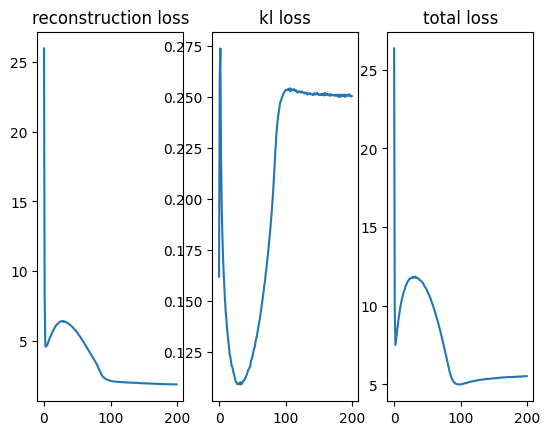

In [22]:
plt.subplot(1, 3, 1)
plt.plot(recon_loss1)
plt.title('reconstruction loss')
plt.subplot(1, 3, 2)
plt.plot(kl_loss1)
plt.title('kl loss')
plt.subplot(1, 3, 3)
plt.plot(total_loss1)
plt.title('total loss')

In [23]:
imgs_recon = cntrlvae(print_imgs.to(DEVICE).float())[0]
imgs_recon = nn.Sigmoid()(imgs_recon).cpu().detach().numpy()

Text(0.5, 1.0, 'reconstructed images')

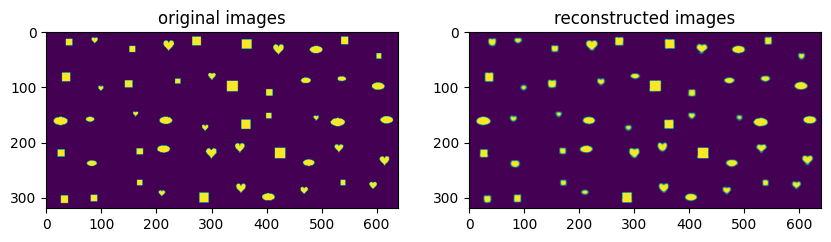

In [24]:
org = image_grid(np.array(print_imgs))
rec = image_grid(np.array(imgs_recon))
fig = plt.figure(figsize=(10., 10.))
plt.subplot(1, 2, 1)
plt.imshow(org)
plt.title('original images')
plt.subplot(1, 2, 2)
plt.imshow(rec)
plt.title('reconstructed images')

In [25]:
!rm -rf aa
!rm -rf bb
!mkdir aa
!mkdir bb

In [26]:
imgs_recon = cntrlvae(print_imgs.to(DEVICE).float())[0]
imgs_recon = nn.Sigmoid()(imgs_recon).cpu().detach().numpy()

In [27]:
cnt = 0
for i in imgs_recon:
  cnt += 1
  result = Image.fromarray((i[0] * 255).astype(np.uint8))
  result.save('./aa/'+str(cnt)+'.bmp')
cnt = 0
for i in test_imgs:
  cnt += 1
  result = Image.fromarray((np.array(i[0]) * 255).astype(np.uint8))
  result.save('./bb/'+str(cnt)+'.bmp')

In [28]:
!python -m pytorch_fid './aa' './bb' --dims 64 --device cuda:0

100% 1/1 [00:00<00:00,  3.05it/s]
100% 1/1 [00:00<00:00,  7.80it/s]
FID:  0.00915508459576908


# **ControlVAE Model - sp=14**

In [29]:
epochs = 200

latent_dim = 10
encoder = Encoder(latent_dim).to(DEVICE)
decoder = Decoder(latent_dim).to(DEVICE)
cntrlvae2 = VAE(encoder, decoder).to(DEVICE)

# Define the optimizer and loss function
optimizer = optim.Adam(cntrlvae2.parameters(), lr=0.0001, betas=[0.9, 0.99])
criterion = VAE_Loss()

# Assuming you have a training dataset (train_dataset)
train_loader = DataLoader(imgs, batch_size=32, shuffle=True)

# Train the VAE
recon_loss2, kl_loss2, total_loss2 = train_cntrlvae(cntrlvae2, train_loader, optimizer, criterion, epochs, 14, DEVICE)

Epoch 1/200, Loss: 28.1085
Epoch 2/200, Loss: 12.4481
Epoch 3/200, Loss: 7.5901
Epoch 4/200, Loss: 8.0663
Epoch 5/200, Loss: 8.4590
Epoch 6/200, Loss: 8.8232
Epoch 7/200, Loss: 9.1803
Epoch 8/200, Loss: 9.5465
Epoch 9/200, Loss: 9.8450
Epoch 10/200, Loss: 10.1307
Epoch 11/200, Loss: 10.3906
Epoch 12/200, Loss: 10.6007
Epoch 13/200, Loss: 10.8069
Epoch 14/200, Loss: 11.0019
Epoch 15/200, Loss: 11.1801
Epoch 16/200, Loss: 11.3287
Epoch 17/200, Loss: 11.4612
Epoch 18/200, Loss: 11.5724
Epoch 19/200, Loss: 11.7068
Epoch 20/200, Loss: 11.7889
Epoch 21/200, Loss: 11.8359
Epoch 22/200, Loss: 11.8891
Epoch 23/200, Loss: 11.9755
Epoch 24/200, Loss: 12.0562
Epoch 25/200, Loss: 12.0796
Epoch 26/200, Loss: 12.0772
Epoch 27/200, Loss: 12.1077
Epoch 28/200, Loss: 12.1220
Epoch 29/200, Loss: 12.1214
Epoch 30/200, Loss: 12.1458
Epoch 31/200, Loss: 12.1452
Epoch 32/200, Loss: 12.1786
Epoch 33/200, Loss: 12.2111
Epoch 34/200, Loss: 12.1336
Epoch 35/200, Loss: 12.1171
Epoch 36/200, Loss: 12.0981
Epoch 37

Text(0.5, 1.0, 'total loss')

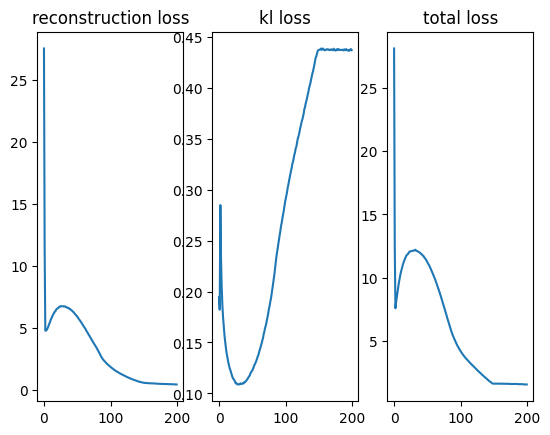

In [30]:
plt.subplot(1, 3, 1)
plt.plot(recon_loss2)
plt.title('reconstruction loss')
plt.subplot(1, 3, 2)
plt.plot(kl_loss2)
plt.title('kl loss')
plt.subplot(1, 3, 3)
plt.plot(total_loss2)
plt.title('total loss')

In [31]:
imgs_recon = cntrlvae2(print_imgs.to(DEVICE).float())[0]
imgs_recon = nn.Sigmoid()(imgs_recon).cpu().detach().numpy()

Text(0.5, 1.0, 'reconstructed images')

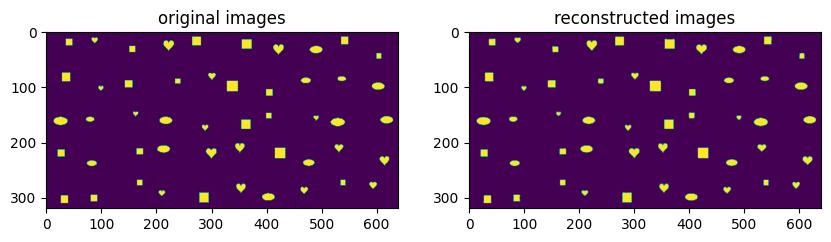

In [32]:
org = image_grid(np.array(print_imgs))
rec = image_grid(np.array(imgs_recon))
fig = plt.figure(figsize=(10., 10.))
plt.subplot(1, 2, 1)
plt.imshow(org)
plt.title('original images')
plt.subplot(1, 2, 2)
plt.imshow(rec)
plt.title('reconstructed images')

In [33]:
!rm -rf aa
!rm -rf bb
!mkdir aa
!mkdir bb

In [34]:
imgs_recon = cntrlvae2(print_imgs.to(DEVICE).float())[0]
imgs_recon = nn.Sigmoid()(imgs_recon).cpu().detach().numpy()

In [35]:
cnt = 0
for i in imgs_recon:
  cnt += 1
  result = Image.fromarray((i[0] * 255).astype(np.uint8))
  result.save('./aa/'+str(cnt)+'.bmp')
cnt = 0
for i in test_imgs:
  cnt += 1
  result = Image.fromarray((np.array(i[0]) * 255).astype(np.uint8))
  result.save('./bb/'+str(cnt)+'.bmp')

In [36]:
!python -m pytorch_fid './aa' './bb' --dims 64 --device cuda:0

100% 1/1 [00:00<00:00,  2.67it/s]
100% 1/1 [00:00<00:00,  7.28it/s]
FID:  0.0023485358423905867


# **plots of losses of sp=8 & sp=14 in one**

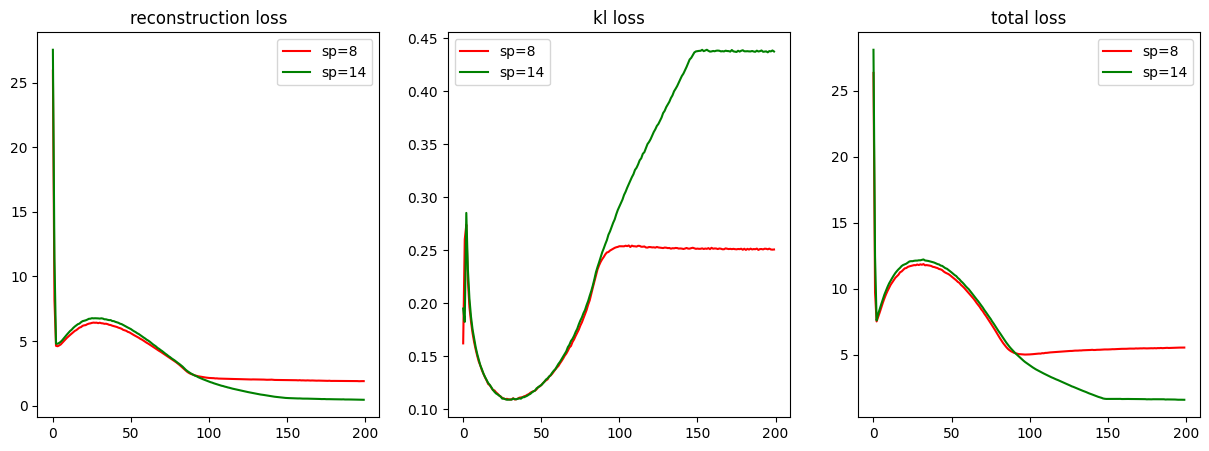

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(recon_loss1, color='r', label='sp=8')
axs[0].plot(recon_loss2, color='g', label='sp=14')
axs[0].set_title("reconstruction loss")
axs[0].legend()



axs[1].plot(kl_loss1, color='r', label='sp=8')
axs[1].plot(kl_loss2, color='g', label='sp=14')
axs[1].set_title("kl loss")
axs[1].legend()



axs[2].plot(total_loss1, color='r', label='sp=8')
axs[2].plot(total_loss2, color='g', label='sp=14')
axs[2].set_title("total loss")
axs[2].legend()

plt.show()
